In [1]:
#import libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

C:\Users\lenovo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#class inputs
base_path = r"C:\Users\lenovo\USNThesis\CWRU"

image_directories = [
    base_path + "\\spectogtam\\bopolar7",
    base_path + "\\spectogtam\\bopolar14",
    base_path + "\\spectogtam\\bopolar21",
    base_path + "\\spectogtam\\irpolar7",
    base_path + "\\spectogtam\\irpolar14",
    base_path + "\\spectogtam\\irpolar21",
    base_path + "\\spectogtam\\orpolar7",
    base_path + "\\spectogtam\\orpolar14",
    base_path + "\\spectogtam\\orpolar21",
]


In [3]:
#class labeling
def get_label(directory):
    if "bopolar" in directory:
        return 0  
    elif "irpolar" in directory:
        return 1 
    else:
        return 2  


In [4]:
pimages = []
plabels = []
for directory in image_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.png'):
            file_path = os.path.join(directory, file)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            pimages.append(img)
            plabels.append(get_label(directory))

In [5]:
images = np.array(pimages)
labels = np.array(plabels)

In [6]:
# splitting
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
#Generating class weight
class_counts = Counter(labels)
total_samples = len(labels)
class_weights = {class_index: total_samples / (class_count * len(class_counts)) for class_index, class_count in class_counts.items()}


In [8]:
#generate data as a data augmentation step
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

In [9]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
#model training
epochs_list = [20, 30]
batch_sizes = [32, 64]
results = []
best_accuracy = 0.0

for epoch in epochs_list:
    for batch_size in batch_sizes:
        print(f"Training with {epoch} epochs and {batch_size} batch size...")
    
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history = model.fit(X_train, y_train,
                            epochs=epoch,
                            batch_size=batch_size,
                            validation_split=0.2,
                            class_weight=class_weights)
        
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        predictions = model.predict(X_test)
        predicted_labels = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(y_test, predicted_labels)
        f1 = f1_score(y_test, predicted_labels, average='weighted')
        precision_vals = precision_score(y_test, predicted_labels, average=None)
        recall_vals = recall_score(y_test, predicted_labels, average=None)

        n_classes = 3 
        fpr = dict()
        tpr = dict()
        roc_auc_vals = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test, predictions[:, i], pos_label=i)
            roc_auc_vals[i] = auc(fpr[i], tpr[i])

        results.append({
            'epochs': epoch,
            'batch_size': batch_size,
            'test_accuracy': test_accuracy,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision_vals,
            'recall': recall_vals,
            'roc_auc': roc_auc_vals
        })



Training with 20 epochs and 32 batch size...
Epoch 1/20
36/36 [==============================] - 34s 830ms/step - loss: 0.8245 - accuracy: 0.6363 - val_loss: 0.5722 - val_accuracy: 0.7562
Epoch 2/20
36/36 [==============================] - 29s 799ms/step - loss: 0.6059 - accuracy: 0.7531 - val_loss: 0.5054 - val_accuracy: 0.7915
Epoch 3/20
36/36 [==============================] - 29s 798ms/step - loss: 0.5044 - accuracy: 0.7965 - val_loss: 0.4226 - val_accuracy: 0.8057
Epoch 4/20
36/36 [==============================] - 29s 816ms/step - loss: 0.4762 - accuracy: 0.8159 - val_loss: 0.4290 - val_accuracy: 0.8127
Epoch 5/20
36/36 [==============================] - 30s 838ms/step - loss: 0.4513 - accuracy: 0.8239 - val_loss: 0.3410 - val_accuracy: 0.8269
Epoch 6/20
36/36 [==============================] - 30s 841ms/step - loss: 0.4017 - accuracy: 0.8310 - val_loss: 0.3264 - val_accuracy: 0.8269
Epoch 7/20
36/36 [==============================] - 30s 842ms/step - loss: 0.3565 - accuracy: 0.8

In [11]:
# print Validation, Accuracy, F1-Score
for result in results:
    print(f"Epochs: {result['epochs']}, Batch Size: {result['batch_size']},  Test Accuracy: {result['test_accuracy']}, F1-Score: {result['f1_score']}")


Epochs: 20, Batch Size: 32,  Test Accuracy: 0.9406779408454895, F1-Score: 0.9406693651382262
Epochs: 20, Batch Size: 64,  Test Accuracy: 0.9548022747039795, F1-Score: 0.9553143995787036
Epochs: 30, Batch Size: 32,  Test Accuracy: 0.9774011373519897, F1-Score: 0.9774196192948866
Epochs: 30, Batch Size: 64,  Test Accuracy: 0.9858757257461548, F1-Score: 0.9859323030844066


In [12]:
#best results
best_result_test = max(results, key=lambda x: x['test_accuracy'])
print("\nBest Hyperparameters (Test Accuracy):")
print("Epochs:", best_result_test['epochs'])
print("Batch Size:", best_result_test['batch_size'])
print("Test Accuracy:", best_result_test['test_accuracy'])


Best Hyperparameters (Test Accuracy):
Epochs: 30
Batch Size: 64
Test Accuracy: 0.9858757257461548


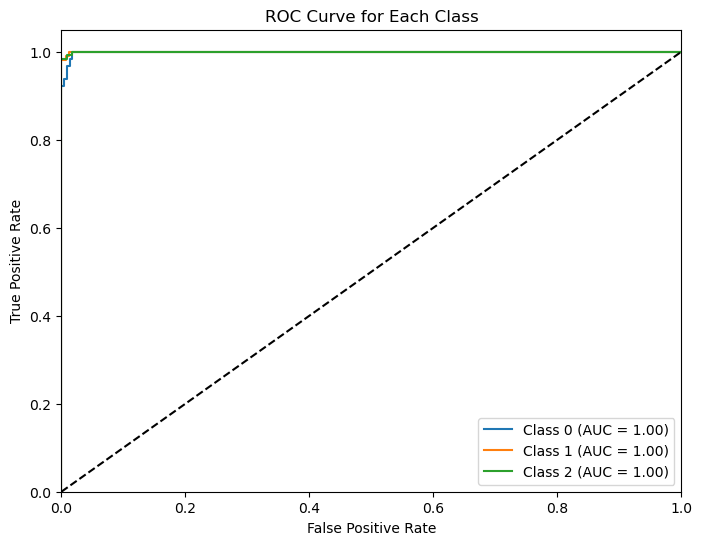

In [13]:
#plot roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3  

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [14]:
precision = precision_score(y_test, predicted_labels, average=None)
recall = recall_score(y_test, predicted_labels, average=None)

print("\nPrecision for Each Class:", precision)
print("Recall for Each Class:", recall)



Precision for Each Class: [0.96212121 1.         1.        ]
Recall for Each Class: [1.         0.98076923 0.97560976]


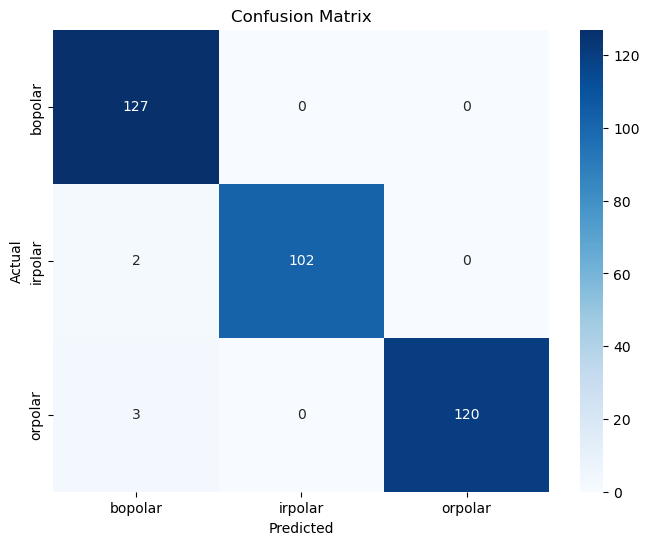

In [15]:
#plot conf_matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
class_labels = ['bopolar', 'irpolar', 'orpolar']
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
